<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V2_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

In [104]:
data_shaperr = pd.read_csv('/content/Shap_error_data.csv')
data_shaperr.head()

,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,Shap_race_Native American,Shap_race_Other,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type
0,-0.746845,-0.094066,-0.494734,0.494734,0.981167,-0.067641,-0.716158,-0.313915,-0.052726,-0.239983,...,0.035609,-0.144069,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN
1,0.426714,0.111220,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,3.185577,-0.052726,-0.239983,...,0.035609,0.275522,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN
2,-1.165973,-0.504638,-0.494734,0.494734,-1.019194,-0.067641,1.396340,-0.313915,-0.052726,-0.239983,...,0.035609,0.531565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.746845,0.727079,-0.494734,0.494734,-1.019194,-0.067641,1.396340,-0.313915,-0.052726,-0.239983,...,0.035609,0.192882,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP
4,0.007586,-0.709925,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,3.185577,-0.052726,-0.239983,...,0.035609,-0.221036,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP


# Data preparation

In [105]:
META_COL = ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters']
SHAP_COL = ['Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male',
            'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
            'Shap_race_Native American', 'Shap_race_Other']
BASIC_COL = ['age', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other'] #'error_scaled' ]
META_COL_VIZ = ['predicted_class', 'true_class', 'TP', 'TN', 'FN', 'FP', 'error_scaled', 'Error_Type', 'new_clusters']
DUMMY_RACE = ['race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other']
SHORT_LABEL_RACE = ['Afr.Am.', 'Asian', 'Cauc.', 'Hisp.', 'Native', 'Other']
DUMMY_GENDER = ['sex_Female', 'sex_Male']
SHORT_LABEL_GENDER = ['Female', 'Male']


In [106]:
'''Drop rows where both TP and FN are 0 '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_data = drop_zero_TP_FN(data_shaperr)
TNFP_data = drop_zero_TN_FP(data_shaperr)

#TNFP_data.head()
#TPFN_data.info()

In [107]:
'''Initialize dataset to scale the features and errors which can be in/excluded for clustering.
Returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which is required for HBAC '''

def initialize_dataset(data, with_errors=True, just_features=True, scale_features=True, with_classes=True, with_Dummy= True):

    new_data = data.copy(deep=True).dropna() #remove rows with NaN values

    #Seperate features before scaling - drop metacols from features for scaling
    features = new_data.drop(META_COL, errors='ignore')

    if just_features: #Check if thecolumns exist before dropping
      new_data = new_data.drop(columns=META_COL, errors = 'ignore')
      if 'clusters' in new_data.columns:
        new_data = new_data.drop('clusters', axis=1)
      if 'new_clusters' in new_data.columns:
        new_data = new_data.drop('new_clusters', axis=1)

    if with_Dummy:
      for col in DUMMY_RACE + DUMMY_GENDER:
        if col in new_data.columns:
          one_hot = pd.get_dummies(new_data[col], prefix=col)
          new_data = new_data.drop(col, axis=1) #drop original dummy columns
          new_data = pd.concat([new_data, one_hot], axis=1)

    if scale_features:
      '''Ensure only numeric columns are scaled + try using minmax and standard scaler'''
      numeric_cols = features.select_dtypes(include=['number']).columns
      new_data[numeric_cols] = StandardScaler().fit_transform(features[numeric_cols])
      #new_data[numeric_cols] = MinMaxScaler().fit_transform(features[numeric_cols])

    if with_errors:
        error_columns = ['TP', 'TN', 'FN', 'FP', 'errors']
        if all(col in new_data.columns for col in error_columns):
          new_data[error_columns] *= 0.8 #scaling factor

    if with_classes: #making sure that the class columns are retained in new dataset
      for col in META_COL:
        if col in data.columns:
          new_data[col] = data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

In [108]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

# UTILS for BIAS in ERROR DIFFERENCE

In [109]:
#Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error()
def get_error_rate(data, column = 'errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty cluster')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate #data.loc[:, 'errors'].mean()

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all', #function= get_error_rate
                   ):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  elif baseline == 'best':
    best_cluster = get_min_bias_cluster(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  else:
    print ('unknown baseline')
    return

  #if full_info:
    #return [error_diff, function(cluster_x), function(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

# UTILS for VISUALS

In [110]:
def pca_plot(data, title, alpha):
    # Extract features for PCA and drop Meta_colums
    pca_features = data.drop(META_COL, axis=1)
    other_features = data[META_COL]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha = 0.5):
    # Extract features for TSNE and drop Meta_colums
    tsne_features = data.drop(META_COL, axis=1)
    other_features = data[META_COL]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()


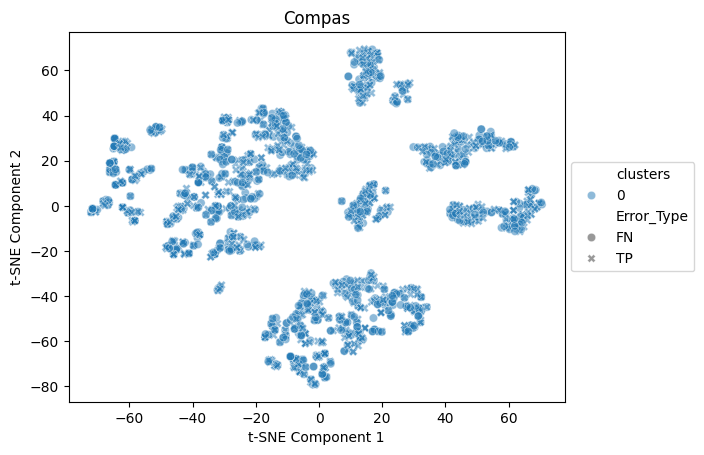

In [111]:
TP_FN = initialize_dataset(TPFN_data)
#pca_plot(TP_FN, 'Compas', 0.6)
tsne_plot(TP_FN, 'Compas', 30, 200, 1000)

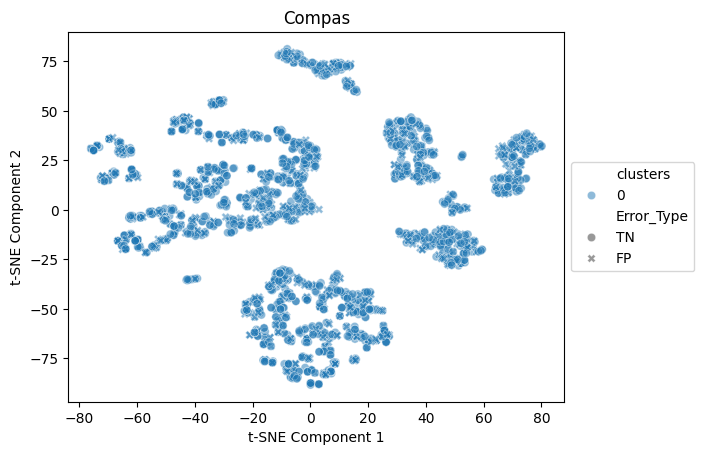

In [112]:
TN_FP = initialize_dataset(TNFP_data)
#pca_plot(TN_FP, 'Compas', 0.6)
tsne_plot(TN_FP, 'Compas', 30, 200, 1000)

# UTILS FOR CLUSTERING

In [113]:
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0 #min possible bias
  max_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue

    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find highest bias

    #if isinstance(current_bias, list):
     # current_bias = current_bias[0]

    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

    return(max_bias_cluster, max_bias)

#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all'):
  min_bias = 1 #max possible bias and look for smt smaller
  min_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id
  return(min_bias_cluster, min_bias)

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue
      print ('This is the random cluster we picked:', candidate_cluster_id)

      candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
      if len(candidate_cluster) >= min_splittable_cluster_size:
        print('it is too small:', len(candidate_cluster))
        continue
      else:
        return candidate_cluster_id

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


# K-MEANS CLUSTERING

TP FN DATA

In [114]:
#TP FN DATA
def hbac_kmeans(data = TP_FN, max_iter = 300, show_plot= True):
  clus_model_kwargs = { "n_clusters": 2, #split in two clusters
    "init": "k-means++", # method for initializing k-means++: first centroid is chosen randomly and subsequent centriods are selected based on max distance from the nearest centriod
    "n_init": 10, #K-means is sensitive to the initial placement of cluster centers - running it 10 times with different initial seeds
    "max_iter": max_iter,} #max mr of iterations for k-means in a single run. If convergence is not achieved within 300 the algorithm stops

  x = 0 #initial cluster nr
  initial_bias = 0

  error_list = []
  error_rate = get_error_rate(data, column = 'FN') #Calculating mean error rate on FN column

  min_splittable_cluster_size = round(0.05 * len(data))
  min_acceptable_cluster_size = round(0.03 * len(data))
  print("error rate:", error_rate)

  #Loop for clustering iterations
  for i in range(1, max_iter):
    if len(data['clusters'].unique()) != 1:
      error_list.append(get_error_rate(data)) #the error rate is calculated if the nr of unique clusters is not equal to 1
      data['new_clusters'] = -1
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
      continue

    kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(META_COL,axis=1))

    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans.predict(candidate_cluster.drop(META_COL, axis=1)), index=candidate_cluster.index)
    data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

    discr_bias = get_error_diff(data, x, 'clusters', bias_type = 'negative', baseline= 'all')
    print('discriminative bias:', discr_bias)

    min_cluster_size = get_min_cluster_size(data)
    print('Smallest cluster size:', min_cluster_size)

    if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
      print ("adding a new cluster")
      n_cluster = max(data['clusters'])
      data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

      if show_plot:
        #pca_plot(data, 'K-means for False Negatives', 0.6)
        tsne_plot(data, 'K-means for False Negatives', perplexity = 30, learning_rate = 200, n_iter = 1000, alpha = 0.5)
        plt.show()

      x = select_new_cluster(data, error_column = 'FN')
      initial_bias = discr_bias

    else:
      x = get_random_cluster(data,'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

  print('MAX_ITER')
  print(error_list)
  return data


In [115]:
hbac_kmeans(data = TP_FN, max_iter = 300, show_plot= False) #True)
plt.show()

error rate: 0.4749841671944269
discriminative bias: 0.0
Smallest cluster size: 1579
adding a new cluster
discriminative bias: 0.015699062619237703
Smallest cluster size: 1579
adding a new cluster
discriminative bias: 0.05019568892068099
Smallest cluster size: 1579
adding a new cluster
discriminative bias: -0.004021557806996479
Smallest cluster size: 1579
MAX_ITER
[0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.4749841671944269, 0.47498416719

In [116]:
c= get_max_bias_cluster(TP_FN)
#highest_bias_cluster = TP_FN[TP_FN['clusters']==c]
#len(highest_bias_cluster)

Mean_error_rate_TPFN = get_error_rate(TP_FN)

print ('Mean error rate of full TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")


Mean error rate of full TPFN data set: 0.4749841671944269
 cluster (3, 0.10526274638582006) has the highest discrimination bias for TPFN data


TN FP DATA

In [117]:
'''TN FP DATA'''
def hbac_kmeans(data = TN_FP, max_iter = 300, show_plot= True):
  clus_model_kwargs = { "n_clusters": 2, "init": "k-means++", "n_init": 10, "max_iter": max_iter,}

  x = 0 #initial cluster nr
  initial_bias = 0

  error_list = []
  error_rate = get_error_rate(data, column = 'FP') #Calculating mean error rate on FP column

  min_splittable_cluster_size = round(0.05 * len(data))
  min_acceptable_cluster_size = round(0.03 * len(data))
  print("error rate:", error_rate)

  #Loop for clustering iterations
  for i in range(1, max_iter):
    if len(data['clusters'].unique()) != 1:
      error_list.append(get_error_rate(data)) #the error rate is calculated if the nr of unique clusters is not equal to 1
      data['new_clusters'] = -1
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
      continue

    kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(META_COL,axis=1))

    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans.predict(candidate_cluster.drop(META_COL, axis=1)), index=candidate_cluster.index)
    data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

    discr_bias = get_error_diff(data, x, 'clusters', bias_type = 'negative', baseline= 'all')
    print('discriminative bias:', discr_bias)

    min_cluster_size = get_min_cluster_size(data)
    print('Smallest cluster size:', min_cluster_size)

    if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
      print ("adding a new cluster")
      n_cluster = max(data['clusters'])
      data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

      if show_plot:
        #pca_plot(data, 'K-means for False Positives', 0.6)
        tsne_plot(data, 'K-means for False Negatives', perplexity = 30, learning_rate = 200, n_iter = 1000, alpha = 0.5)
        plt.show()

      x = select_new_cluster(data, error_column = 'FP')
      initial_bias = discr_bias

    else:
      x = get_random_cluster(data,'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

  print('MAX_ITER')
  print(error_list)
  return data

In [118]:
hbac_kmeans(data = TN_FP, max_iter = 300, show_plot= False) #True)

error rate: 0.33145780051150897
discriminative bias: 0.0
Smallest cluster size: 1955
adding a new cluster
discriminative bias: 0.013085346696612876
Smallest cluster size: 1955
adding a new cluster
discriminative bias: 0.01376512942479674
Smallest cluster size: 1955
adding a new cluster
discriminative bias: 0.03273973035268857
Smallest cluster size: 1955
adding a new cluster
discriminative bias: 0.042735747875587815
Smallest cluster size: 1955
adding a new cluster
MAX_ITER
[0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.33145780051150897, 0.3314578005115089

,age,priors_count,Shap_age,Shap_priors_count,Shap_sex_Female,Shap_sex_Male,Shap_race_African-American,Shap_race_Asian,Shap_race_Caucasian,Shap_race_Hispanic,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,clusters,new_clusters
0,-0.778253,-0.108001,0.001035,-0.000080,-0.239140,-0.303325,0.425621,-0.049430,0.787585,0.114219,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,2,-1
3,-0.778253,0.705649,0.042245,-0.661420,0.073102,0.189438,1.039322,0.062252,1.449425,0.154479,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,0,-1
4,-0.033198,-0.718239,0.539532,0.811642,1.257819,1.601799,0.286231,-0.001673,1.377349,2.661094,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,1,-1
7,1.374127,-0.718239,0.456295,0.670854,1.130668,2.118375,0.596555,-0.064947,0.784016,-0.252350,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,1,-1
8,-1.274956,-0.718239,-2.111093,0.969374,-0.143818,-0.136065,1.117120,-0.003482,0.079375,0.142652,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,-0.198766,0.909061,-0.721087,-1.296580,-0.129931,-0.083255,-1.994452,-0.081757,-1.156851,-0.287340,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,2,-1
5042,-1.274956,-0.718239,-2.326628,0.887557,-0.274235,-0.222354,-0.440050,0.142222,0.900889,0.168847,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,0,-1
5045,-0.943821,2.332949,-1.099908,-1.558241,-0.223463,-0.207733,-1.013140,-0.109717,-0.300944,-0.305629,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,2,-1
5047,-0.529901,0.502236,-1.173355,-1.702646,-0.363926,-0.394545,-0.557291,-0.094529,0.047687,-0.137147,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,2,-1


In [119]:
c= get_max_bias_cluster(TN_FP)

Mean_error_rate_TNFP = get_error_rate(TN_FP)

print ('Mean error rate of full TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TNFP data")


Mean error rate of full TNFP data set: 0.33145780051150897
 cluster (2, 0.012410720348162319) has the highest discrimination bias for TNFP data


# ANOVA SIGNIFICANCE TESTING

In [120]:
'''SHAP, ERROR & BASIC COLUMNS FOR TPFN ANOVA'''
groupstpfn = TP_FN.groupby('clusters')['FN'].apply(list)
anovatpfn = [np.array(groupstpfn) for groupstpfn in groupstpfn]

f_stat, p_val = f_oneway(*anovatpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 1.309071337288419
p-value: 0.2698362799455414
there are no statistically significant differences between the clusters


In [121]:
'''SHAP, ERROR & BASIC COLUMNS FOR TNFP ANOVA'''
groupstnfp = TN_FP.groupby('clusters')['FP'].apply(list)
anovatnfp = [np.array(groupstnfp) for groupstnfp in groupstnfp]

f_stat, p_val = f_oneway(*anovatnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 2.4098073565626486
p-value: 0.034498685320708454
there are statistically significant differences between the clusters.


# SHAP AND ERROR NO FEATURES


**RQ1: is there a relationshop between shap & risk of error?**

TP_FN & TN_FP = *all columns* (above)

SE = shap and error columns

FE = all columns except shap (selma)


--------------------------------------------------
**RQ2: does shap help in finding disc clusters?**

FS = all columns except error

S = only SHAP_COL

F = only BASIC_COL


In [122]:
'''SE DF: Shap and Error '''
SE_tpfn_ = TPFN_data[META_COL + SHAP_COL]
SE_tnfp_ = TNFP_data[META_COL + SHAP_COL]
#SE_tnfp_.drop('Error_Type', axis = 1)

SE_tpfn = initialize_dataset(SE_tpfn_)
SE_tnfp = initialize_dataset(SE_tnfp_)

SE_tpfn.info()
SE_tnfp.info()

KeyError: "['clusters', 'new_clusters'] not in index"

In [ ]:
hbac_kmeans(data = SE_tnfp, max_iter = 300, show_plot= False)
hbac_kmeans(data = SE_tpfn, max_iter = 300, show_plot= False)

In [ ]:
'''SHAP & ERROR COLUMNS FOR TPFN ANOVA'''
groupsSE_tpfn = SE_tpfn.groupby('clusters')['FN'].apply(list)
anovaSE_tpfn = [np.array(groupsSE_tpfn) for groupsSE_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

In [ ]:
'''SHAP & ERROR COLUMNS FOR TNFP ANOVA'''
groupsSE_tnfp = SE_tnfp.groupby('clusters')['FP'].apply(list)
anovaSE_tnfp = [np.array(groupsSE_tnfp) for groupsSE_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaSE_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# ERROR AND FEATURES NO SHAP

In [ ]:
'''FE_df: FEATURES AND ERROR NO SHAP (Selma) '''

FE_tpfn_ = TPFN_data.drop(SHAP_COL, axis = 1) #[BASIC_COL + META_COL + DUMMY_RACE + DUMMY_GENDER]
FE_tnfp_ = TNFP_data.drop(SHAP_COL, axis = 1) #[BASIC_COL + META_COL + DUMMY_RACE + DUMMY_GENDER]

FE_tpfn = initialize_dataset(FE_tpfn_)
FE_tnfp = initialize_dataset(FE_tnfp_)

#FE_tpfn_.info()
FE_tpfn.info()
#FE_tnfp.info()
#FE_tnfp_.info()